In [38]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import mmcv
from PIL import Image
from tqdm.auto import tqdm, trange
import os
import glob

In [3]:


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = torchvision.transforms.functional.to_pil_image(inp)
    plt.imshow(inp)
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [4]:
vid_file = 'videos/IMG_2139.MOV'
vid = mmcv.video.VideoReader(vid_file)

In [5]:
#from data import VideoFrameFolder
# data_transforms = {
#     'train': transforms.Compose([
#         #transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
#     'val': transforms.Compose([
#         transforms.ToTensor(),
#         #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ]),
# }


# val_dataset = VideoFrameFolder('/home/tormod/ucph-erda-home/frames/',
#                               transform=data_transforms['val'])
# val_dataloader = torch.utils.data.DataLoader(val_dataset,
#                                             batch_size=30,
#                                             shuffle=False,
#                                             num_workers=8)

## MMTracking

In [6]:
import mmtrack
import bbox
from mmtrack.apis import init_model


In [7]:
track_model = init_model('../mmtracking/configs/mot/tracktor/tracktor_faster-rcnn_r50_fpn_4e_mot17-private.py')
#track_model = init_model('../mmtracking/configs/vid/selsa/selsa_faster_rcnn_r50_dc5_1x_imagenetvid.py')
#track_model = init_model('../mmtracking/configs/vid/dff/dff_faster_rcnn_r50_dc5_1x_imagenetvid.py')

2021-03-23 13:30:04,345 - mmtrack - INFO - load detector from: https://download.openmmlab.com/mmtracking/mot/faster_rcnn/faster-rcnn_r50_fpn_4e_mot17-ffa52ae7.pth
2021-03-23 13:30:04,346 - mmtrack - INFO - Use load_from_http loader
2021-03-23 13:30:04,478 - mmtrack - INFO - load reid from: https://download.openmmlab.com/mmtracking/mot/reid/tracktor_reid_r50_iter25245-a452f51f.pth
2021-03-23 13:30:04,479 - mmtrack - INFO - Use load_from_http loader


In [8]:
bboxes = bbox.detect_mot(track_model, vid, only_first=10)
    

/home/tormod/anaconda3/envs/apec/lib/python3.6/site-packages/mmdet/models/dense_heads/rpn_head.py:192: UserWarning: In rpn_proposal or test_cfg, nms_thr has been moved to a dict named nms as iou_threshold, max_num has been renamed as max_per_img, name of original arguments and the way to specify iou_threshold of NMS will be deprecated.
  'In rpn_proposal or test_cfg, '


In [9]:
np.convolve(bboxes[:,0], np.ones(5)/5, mode='same')

array([152.78586426, 204.24011841, 255.07853088, 255.24468079,
       253.52329102, 251.38067017, 249.22415771, 247.64385071,
       197.54999084, 147.99832764])

In [10]:
#mmcv.frames2video('tmp_frames', 'zoom_test.mp4', fps=vid.fps)

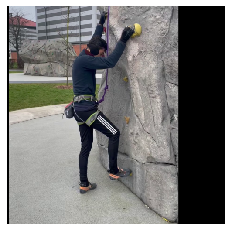

In [11]:
imshow(bbox.bbox_crop(vid[1], bboxes[1]))

# MMPose

In [71]:
from mmpose.apis import init_pose_model
from mesh import inference_mesh_model, get_vertices

In [73]:
pose_model = init_pose_model('mmpose/configs/hmr_res50_224x224.py')

In [75]:
pose_model.eval()
person_results = [dict(bbox=bboxes[1])]
_, res = inference_mesh_model(pose_model, 
                              vid[1], 
                              person_results,
                              format='xyxy')

In [79]:
verts = get_vertices(pose_model, res)
verts.shape

(1, 6890, 3)

In [80]:
import sys
sys.path.append('../MEVA/')

In [84]:
from  meva.utils.demo_utils import convert_crop_cam_to_orig_img
from meva.utils.renderer import Renderer

In [97]:
orig_width, orig_height = vid[1].shape[1], vid[1].shape[0]
orig_cam = convert_crop_cam_to_orig_img(res['cam'], bbox.xyxy2xywh(bboxes[1][np.newaxis]), orig_width, orig_height)

In [99]:
renderer = Renderer(resolution=(orig_width, orig_height), orig_img=True)

In [100]:
renderer.render(vid[1], verts, orig_cam)

ValueError: matrix shape ((4, 4)) doesn't match points ((1, 6890, 3))